# CASAPose Inference Notebook

### Step-by-step visual tool to view frames

In [1]:
from __future__ import print_function

import os
import sys
import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

from casapose.utils.geometry_utils import apply_offsets, project
from tensorflow.python.ops.numpy_ops import np_config
from casapose.utils.draw_utils import draw_bb, draw_axes
from casapose.data_handler.image_only_dataset import ImageOnlyDataset
from casapose.pose_estimation.pose_evaluation import poses_pnp
from casapose.pose_estimation.voting_layers_2d import CoordLSVotingWeighted
from casapose.pose_models.tfkeras import Classifiers
from casapose.utils.config_parser import parse_config

In [2]:
sys.path.extend([".", ".."])  # adds the folder from which you call the script
os.environ["CASAPOSE_INFERENCE"] = "True"

opts = {'data': '', 
 'data_path_filter': None, 
 'datatest': 'import_data/test/', 
 'datatest_path_filter': None, 
 'color_dataset': True, 
 'data_wxyz_quaterion': False, 
 'datatest_wxyz_quaterion': False, 
 'datameshes': 'import_data/test/models', 
 'modelname': 'casapose_c_gcu5', 
 'backbonename': 'resnet18', 'train_validation_split': 0.9, 'estimate_confidence': True, 
 'estimate_coords': True, 'confidence_regularization': True, 'confidence_filter_estimates': True, 
 'confidence_choose_second': False, 'mask_loss_weight': 1.0, 'vertex_loss_weight': 0.5, 
 'proxy_loss_weight': 0.015, 'keypoint_loss_weight': 0.007, 'filter_vertex_with_segmentation': True, 
 'filter_high_proxy_errors': False, 'use_bpnp_reprojection_loss': False, 'max_keypoint_pixel_error': 12.5, 
 'object': 'obj_000001,obj_000005,obj_000006,obj_000008,obj_000009,obj_000010,obj_000011,obj_000016', 
 'no_points': 9, 'workers': 0, 'prefetch': 10, 'pretrained': True, 'batchsize': 4, 
 'imagesize': (448, 448), 'imagesize_test': (480, 640), 'lr': 0.001, 'lr_decay': 0.5, 'lr_epochs': 15,
 'lr_epochs_start': 0, 'lr_epochs_steps': [50, 75, 90], 'noise': 0.0001, 'contrast': 0.001, 
 'brightness': 0.001, 'saturation': 0.001, 'hue': 0.001, 'use_imgaug': True, 'rotation': 0.0, 
 'translation': 0.0, 'crop_factor': 0.933333333, 'epochs': 100, 'loginterval': 10, 'saveinterval': 5, 
 'validationinterval': 1, 'save_debug_batch': False, 'save_eval_batches': True, 'write_poses': False, 
 'filter_test_with_gt': False, 'min_object_size_test': 200, 'net': 'training_checkpoints', 'manualseed': 1237, 
 'outf': 'output/train_casapose_8_16_objects', 
 'evalf': 'output/train_casapose_8_16_objects/train_casapose_8_16_objects', 'gpuids': [0, 1], 
 'train_vectors_with_ground_truth': False, 'load_h5_weights': True, 
 'load_h5_filename': '../../../data/pretrained_models/result_w', 
 'copy_weights_from_backup_network': False, 'copy_weights_add_confidence_maps': False, 
 'objects_to_copy': np.array([[0, 0],
                               [1, 1],
                               [2, 2],
                               [3, 3],
                               [4, 4],
                               [5, 5],
                               [6, 6],
                               [7, 7],
                               [8, 8]]), 
        'objects_in_input_network': 8, 
        'objects_to_copy_list': 'config/objects_to_copy.csv'}

class parse(object):
    def __init__(self, var):
        for key, value in var.items():
            setattr(self, key, value)
            
opt = parse(opts)

In [3]:
keypoints_array = np.array([[[[[-9.7732497e-03, 3.6659201e-03, -1.4534000e-03],
                               [3.6046398e+01, -1.4680500e+01, -4.5020599e+01],
                               [-3.0289101e+01, -7.2402501e+00, -4.2632900e+01],
                               [7.4425201e+00, 2.3966400e+01, -3.9362701e+01],
                               [-4.3485899e+00, 3.6769500e+00, 4.5835800e+01],
                               [6.2882501e-01, -3.6412800e+01, -2.7732599e+01],
                               [-2.6754901e-01, 3.7588799e+01, -4.7640200e+00],
                               [3.0029400e+01, -2.3939800e+01, -8.1097898e+00],
                               [-2.8789900e+01, -1.9449200e+01, -9.0417604e+00]]],

                             [[[1.6300200e-02, -2.3040799e-03, -1.1291500e-02],
                               [5.5248199e+00, 5.4157101e+01, -9.6322701e+01],
                               [-4.1018100e+00, 1.2732400e+01, 9.6678497e+01],
                               [-9.1580000e+00, -4.1244202e+01, -8.7472397e+01],
                               [7.3375401e+00, 9.0886101e+01, -1.1365300e+01],
                               [-1.0262200e+01, -9.0547600e+01, -3.7563899e-01],
                               [-4.7794201e+01, 1.6508699e+01, -5.6376900e+01],
                               [4.8287998e+01, 2.4022501e+00, -6.2877899e+01],
                               [4.6154099e+01, 1.1302400e+01, 4.9851101e+01]]],

                             [[[1.7128000e-02, -4.5700101e-03, -5.3901700e-03],
                               [2.0947300e+01, -6.1587502e+01, -5.4198200e+01],
                               [-2.0933701e+01, 6.3563000e+01, 2.6130899e+01],
                               [2.8901501e+01, 2.7392700e+01, -5.7568199e+01],
                               [1.4403200e+00, -5.8665901e+01, 2.2473900e+01],
                               [1.2946500e+01, 1.4082400e+01, 5.8292999e+01],
                               [-2.8743299e+01, 1.6301001e+01, -5.2558300e+01],
                               [-3.3441200e+01, -4.1310501e+01, -5.4232101e+01],
                               [2.3869900e+01, 4.1699699e+01, 1.6587299e+01]]],

                             [[[-2.4108901e-03, -6.2332200e-03, -6.3247699e-03],
                               [1.1291000e+02, -3.4727199e+00, 9.2172699e+01],
                               [-1.1182900e+02, 3.1709600e-02, 6.1154400e+01],
                               [-6.2377201e+01, 1.0970700e+01, -1.0025700e+02],
                               [4.2661201e+01, -2.4666700e+01, -9.9452499e+01],
                               [1.0724100e+01, -3.5357201e+00, 1.0133300e+02],
                               [-4.1970699e+01, -3.1155399e+01, 5.4645599e+01],
                               [4.9310899e+00, 3.6434399e+01, -9.7123596e+01],
                               [5.6840302e+01, -4.2665200e+00, 4.8058399e+01]]],

                             [[[-3.4179699e-03, -9.8838797e-03, 3.9329501e-03],
                               [4.9320702e+01, 6.2302999e+00, -4.0302898e+01],
                               [-4.6246700e+01, 2.3396499e+00, -3.7502899e+01],
                               [1.2448000e+01, -3.3365299e+01, -4.0734501e+01],
                               [3.9640200e+00, 3.4297600e+01, -4.0923302e+01],
                               [4.5272598e+01, -1.0067500e+00, 2.1399401e+01],
                               [6.6833901e+00, -3.1548400e+00, 4.2783199e+01],
                               [-2.3509399e+01, -2.7834400e+01, -1.9335600e+01],
                               [-4.1355202e+01, 1.3988900e-01, 1.3391900e+00]]],

                             [[[-1.7417900e-02, -4.2999300e-01, -1.3252300e-02],
                               [-7.0443398e+01, 4.3526299e+01, 4.2999201e+00],
                               [7.3233902e+01, 3.5586300e+01, 4.8644700e+00],
                               [6.7131897e+01, -4.4466202e+01, -2.7725799e+00],
                               [-7.0990898e+01, -3.6974701e+01, -1.3353300e+00],
                               [-4.7924999e+01, 5.5036702e+00, -3.2836399e+01],
                               [2.2584101e+01, 4.1242500e+01, 3.2724400e+01],
                               [-2.4753901e+01, -4.0470100e+01, 3.2213699e+01],
                               [4.7744598e+01, 4.2735401e-01, -3.1653799e+01]]],

                             [[[9.9391900e-03, -1.1459400e-02, 6.8359398e-03],
                               [-9.1147299e+00, -3.1402399e+01, -8.5777802e+01],
                               [9.7676700e-01, 2.9348700e+00, 8.6390404e+01],
                               [6.4356799e+00, 3.7870701e+01, -6.3978802e+01],
                               [9.7071304e+00, -3.6640800e+01, -3.6885799e+01],
                               [-1.5302700e+01, 1.4431200e+00, -4.7971500e+01],
                               [-6.0784298e-01, -1.2160700e+01, 4.3689098e+01],
                               [1.7079800e+01, 1.9666600e+00, -8.3763802e+01],
                               [-4.1084499e+00, 3.5197800e+01, -2.3239799e+01]]],

                             [[[-6.8052673e-01, 4.3509445e+00, -1.5487452e+00],
                               [5.8407185e+01, -8.2160988e+01, -1.2327696e+01],
                               [-9.1078697e+01, -4.6658367e+01, -7.3403926e+00],
                               [9.6684196e+01, 1.5651445e+01, 2.6858237e+00],
                               [-7.8112083e+01, 6.0135139e+01, -6.0886226e+00],
                               [3.1481721e+00, 9.0496506e+01, -1.1837043e+01],
                               [-1.9831656e+01, -8.0089989e+01, -2.5694869e+00],
                               [5.0045956e+01, 5.1196590e+01, -1.4792501e+01],
                               [2.3459833e+01, -4.9363476e+01, 1.9859182e+01]]]]],
                           )
cuboids_array = np.array([[[[-37.92094, -38.788555, -45.88129],
                      [-37.92094, -38.788555, 45.87838],
                      [-37.92094, 38.795883, -45.88129],
                      [-37.92094, 38.795883, 45.87838],
                      [37.901394, -38.788555, -45.88129],
                      [37.901394, -38.788555, 45.87838],
                      [37.901394, 38.795883, -45.88129],
                      [37.901394, 38.795883, 45.87838]]],

                    [[[-50.35713, -90.89071, -96.8516],
                      [-50.35713, -90.89071, 96.82902],
                      [-50.35713, 90.8861, -96.8516],
                      [-50.35713, 90.8861, 96.82902],
                      [50.38973, -90.89071, -96.8516],
                      [50.38973, -90.89071, 96.82902],
                      [50.38973, 90.8861, -96.8516],
                      [50.38973, 90.8861, 96.82902]]],

                    [[[-33.44303, -63.791, -58.71809],
                      [-33.44303, -63.791, 58.707314],
                      [-33.44303, 63.781857, -58.71809],
                      [-33.44303, 63.781857, 58.707314],
                      [33.47729, -63.791, -58.71809],
                      [33.47729, -63.791, 58.707314],
                      [33.47729, 63.781857, -58.71809],
                      [33.47729, 63.781857, 58.707314]]],

                    [[[-114.72308, -37.718895, -103.983604],
                      [-114.72308, -37.718895, 103.97095],
                      [-114.72308, 37.706425, -103.983604],
                      [-114.72308, 37.706425, 103.97095],
                      [114.71827, -37.718895, -103.983604],
                      [114.71827, -37.718895, 103.97095],
                      [114.71827, 37.706425, -103.983604],
                      [114.71827, 37.706425, 103.97095]]],

                    [[[-52.200897, -38.71081, -42.8214],
                      [-52.200897, -38.71081, 42.82927],
                      [-52.200897, 38.691044, -42.8214],
                      [-52.200897, 38.691044, 42.82927],
                      [52.194057, -38.71081, -42.8214],
                      [52.194057, -38.71081, 42.82927],
                      [52.194057, 38.691044, -42.8214],
                      [52.194057, 38.691044, 42.82927]]],

                    [[[-75.0917, -54.39756, -34.629425],
                      [-75.0917, -54.39756, 34.602924],
                      [-75.0917, 53.53758, -34.629425],
                      [-75.0917, 53.53758, 34.602924],
                      [75.05686, -54.39756, -34.629425],
                      [75.05686, -54.39756, 34.602924],
                      [75.05686, 53.53758, -34.629425],
                      [75.05686, 53.53758, 34.602924]]],

                    [[[-18.320473, -38.923126, -86.376724],
                      [-18.320473, -38.923126, 86.3904],
                      [-18.320473, 38.900208, -86.376724],
                      [-18.320473, 38.900208, 86.3904],
                      [18.340351, -38.923126, -86.376724],
                      [18.340351, -38.923126, 86.3904],
                      [18.340351, 38.900208, -86.376724],
                      [18.340351, 38.900208, 86.3904]]],

                    [[[-98.16961, -85.56149, -32.21377],
                      [-98.16961, -85.56149, 29.116282],
                      [-98.16961, 94.26338, -32.21377],
                      [-98.16961, 94.26338, 29.116282],
                      [96.808556, -85.56149, -32.21377],
                      [96.808556, -85.56149, 29.116282],
                      [96.808556, 94.26338, -32.21377],
                      [96.808556, 94.26338, 29.116282]]]])

synthetic_image = False
keypoints = tf.convert_to_tensor(keypoints_array, dtype=tf.float16)
cuboids = tf.convert_to_tensor(cuboids_array, dtype=tf.float16)
if synthetic_image:
    camera_matrix = np.array([[[572.4114, 0., 325.2611],
                               [0., 573.57043, 242.049],
                               [0., 0., 1.]]])
else:  # Samsung S22, 640x480
    camera_matrix = [[[345.5395354181145, 0, 319.4688241083385],
                     [0, 345.25337576116874, 237.47917860129158],
                     [0, 0, 1]]]
camera_matrix = tf.convert_to_tensor(camera_matrix, dtype=tf.float16)

2023-04-17 06:45:50.032940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 06:45:50.067179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 06:45:50.067418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 06:45:50.068248: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate 

In [4]:
if not os.path.exists(opt.evalf):
    os.makedirs(opt.evalf)

checkpoint_path = opt.outf + "/" + opt.net

frozen_path = opt.outf + "/frozen_model"
img_out_path = opt.outf + "/control_output"


def create_dir(path):
    try:
        os.makedirs(path)
    except OSError:
        pass


create_dir(img_out_path)

# save the hyper parameters passed
with open(opt.evalf + "/header_eval.txt", "w") as file:
    file.write(str(opt))

# set the manual seed.
np.random.seed(opt.manualseed)
tf.random.set_seed(opt.manualseed)

test_dataset = None

device_ids = []
if len(opt.gpuids) == 1 and opt.gpuids[0] < 0:
    device_ids.append("/cpu:0")
else:
    device_ids.append("/gpu:{}".format(opt.gpuids[0]))
print(device_ids)

objectsofinterest = [x.strip() for x in opt.object.split(",")]
no_objects = len(objectsofinterest)
separated_vectorfields = opt.modelname == "pvnet"

testingdata = None
normal_imgs = [0.5, 0.5]

use_split = False
if opt.data == opt.datatest:
    print("split datasets with ratio {}".format(opt.train_validation_split))
    use_split = True

['/gpu:0']


In [5]:
test_dataset = ImageOnlyDataset(root=opt.datatest)
print(len(test_dataset))

5


In [6]:
opt.datatest

'import_data/test/'

In [7]:
testingdata, test_batches = test_dataset.generate_dataset(1)

In [8]:
input_segmentation_shape = None

if opt.train_vectors_with_ground_truth is True:
    input_segmentation_shape = (
        opt.imagesize_test[0],
        opt.imagesize_test[1],
        1 + no_objects,
    )


height = opt.imagesize_test[0]
width = opt.imagesize_test[1]

CASAPose = Classifiers.get(opt.modelname)
ver_dim = opt.no_points * 2
if opt.modelname == "pvnet":
    ver_dim = ver_dim * no_objects

if opt.estimate_confidence:
    assert separated_vectorfields is not None, "confidence not compaitble with this model"
    ver_dim += opt.no_points

net = CASAPose(
    ver_dim=ver_dim,
    seg_dim=1 + no_objects,
    input_shape=(height, width, 3),
    input_segmentation_shape=input_segmentation_shape,
    weights="imagenet",
    base_model=opt.backbonename,
)

checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")
checkpoint = tf.train.Checkpoint(network=net)  # , optimizer=optimizer)

if opt.load_h5_weights is True:
    # net.load_weights(frozen_path + "/" + opt.load_h5_filename + ".h5", by_name=True, skip_mismatch=True)
    net.load_weights("result_w.h5", by_name=True, skip_mismatch=True)
    

elif opt.net != "":
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

for layer in net.layers:
    layer.trainable = False

net.summary()

with open(opt.evalf + "/speed_eval.csv", "w") as file:
    file.write("batchid,speed \n")

[<KerasTensor: shape=(None, 240, 320, 64) dtype=float32 (created by layer 'relu0')>, <KerasTensor: shape=(None, 120, 160, 64) dtype=float32 (created by layer 'stage2_unit1_relu1')>, <KerasTensor: shape=(None, 60, 80, 128) dtype=float32 (created by layer 'stage3_unit1_relu1')>, <KerasTensor: shape=(None, 60, 80, 256) dtype=float32 (created by layer 'stage4_unit1_relu1')>, <KerasTensor: shape=(None, 60, 80, 512) dtype=float32 (created by layer 'relu1')>]
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)            

In [9]:
def runnetwork(loader_iterator, batches, no_objects):
    
    @tf.function
    def test_step(img_batch):
        start_time = tf.timestamp()
        
        #keypoints = img_batch[4]
        #camera_matrix = img_batch[5]
        
        # print(no_objects)
            
        no_points = opt.no_points
        net_input = [tf.expand_dims(img_batch[0][0], 0)]
        # print(net_input[0].shape)
        output_net = net(net_input, training=False)  # all stages are present here
        # print(output_net.shape)
        output_seg, output_dirs, confidence = tf.split(output_net, [no_objects, no_points * 2, -1], 3)
        # print(output_seg.shape)
        # print(output_dirs.shape)
        # print(confidence.shape)
        
        # print(no_objects)
        coordLSV_in = [output_seg, output_dirs, confidence]
        coords = CoordLSVotingWeighted(
            name="coords_ls_voting",
            num_classes=no_objects,
            num_points=no_points,
            filter_estimates=True,
        )(coordLSV_in)
        # print('COORDS_SHAPE')
        # print(coords.shape)
        poses_est = poses_pnp(
            coords, output_seg, keypoints, camera_matrix, no_objects - 1, min_num=opt.min_object_size_test
        )
        # tf.print(poses_est[0, 0, 0, 0, 0])  # access memory to get sure everything is done

        end_time = tf.timestamp()
        time_needed = end_time - start_time
        return time_needed, poses_est, coords

    speed = []
    img_batches = []
    est_poses = []
    coords_list = []
    
    for batch_idx in tqdm(range(batches)):
        img_batch = loader_iterator.get_next()
        ### IMAGEONLY
        img_batch = tf.expand_dims(img_batch, 0)
        img_batch = tuple(img_batch)
                
        time_needed, poses_est, coords = test_step(img_batch)
        speed.append(time_needed)
        with open(opt.evalf + "/speed_eval.csv", "a") as file:
            s = "{},{:.7f}\n".format(batch_idx + 1, time_needed)
            file.write(s)
            
        img_batches.append(img_batch)
        est_poses.append(poses_est)
        coords_list.append(coords)

    tf.print("average speed: {}".format(tf.reduce_mean(speed[10:])), summarize=-1)

    return loader_iterator, img_batches, est_poses, coords_list

In [10]:
print("Test Batches: {} ".format(test_batches))

testingdata_iterator = iter(testingdata)
img_batch = testingdata_iterator.get_next()

### IMAGEONLY
img_batch = tf.expand_dims(img_batch, 0)
img_batch = tuple(img_batch)

Test Batches: 5.0 


In [11]:
testingdata_iterator = iter(testingdata)

loader_iterator, img_batches, est_poses, coords_list = runnetwork(testingdata_iterator, 
                                                                  int(test_batches),
                                                                  no_objects + 1)

  0%|                                                                         | 0/5 [00:00<?, ?it/s]

Instructions for updating:
Use fn_output_signature instead
[TensorShape([8, 9, 2]), TensorShape([8, 9, 3]), TensorShape([3, 3])]


2023-04-17 06:45:56.587996: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-04-17 06:45:57.665005: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-17 06:45:57.870863: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f30a728a790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-17 06:45:57.870908: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-04-17 06:45:57.879306: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-17 06:45:58.116185: I tensorflow/compiler/jit/xla_compilation_cache.cc:481] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-04-17 06:45:59.6346

average speed: nan


In [12]:
np_config.enable_numpy_behavior()

obj_list = ['obj_000001', 
            'obj_000005', 
            'obj_000006', 
            'obj_000008', 
            'obj_000009', 
            'obj_000010', 
            'obj_000011', 
            'obj_000016']

obj_dict = {
	"obj_000001": "ape",
	"obj_000005": "wateringcan",
	"obj_000006": "cat",
	"obj_000008": "drill",
	"obj_000009": "duck",
	"obj_000010": "eggbox",
	"obj_000011": "glue",
#	"obj_000012": "holepuncher", # replaced with headphones
	"obj_000016": "headphones"
}

colors = {'blue': (255, 0, 0), 'red': (220,20,60), 'white': (255, 255, 255)}
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.6

def draw_bb_inference(
    img, # [480, 640, 3]
    estimated_poses, # [8, 3, 4]
    cuboids, # [8, 1, 8, 3]
    camera_matrix, # [1, 3, 3]
    path,
    file_prefix,
    gt_pose=None, # [8, 1, 3, 4] or [8, 3, 4] (will be reshaped to latter)
    normal=[0.5, 0.5],
):
        
    # image 
    img_keypoints = tf.cast(((img * normal[1]) + normal[0]) * 255, dtype=tf.uint8).numpy()
    img_cuboids = img_keypoints.copy()

    eps = 1e-4
    
    estimated_poses = np.reshape(estimated_poses, (8, 3, 4))
    
    for obj_idx, obj_pose in enumerate(estimated_poses):
        
        inst_idx = 0
        obj_pose_est = estimated_poses[obj_idx].numpy()
        instance_cuboids = cuboids[obj_idx][inst_idx].numpy()
        
        # draw bb - ESTIMATED
        valid_est = np.abs(np.sum(obj_pose_est)) > eps
        if valid_est: 
            #print('est')
            #print(obj_pose_est.shape)
            transformed_cuboid_points2d, _ = project(instance_cuboids, camera_matrix.numpy(), obj_pose_est)   
            transformed_cuboid_points2d = np.reshape(transformed_cuboid_points2d, (8,2))
            draw_bb(transformed_cuboid_points2d, img_cuboids, (0, 255, 0))
            draw_axes(img=img_cuboids, keypoints=transformed_cuboid_points2d)
            
        else: 
            # print(obj_idx)
            # print('skipped obj est')
            continue

        # GT
        if gt_pose is not None: 
            gt_pose = np.reshape(gt_pose, (8, 3, 4))
            instance_pose_gt = gt_poses[obj_idx][inst_idx].numpy()
            valid_gt = np.abs(np.sum(instance_pose_gt)) > eps
            if valid_gt: 
                gt_pose_est = gt_pose[obj_idx].numpy()
                transformed_cuboid_points2d_gt, _ = project(instance_cuboids,camera_matrix.numpy(), gt_pose_est)   
                draw_bb(transformed_cuboid_points2d_gt, img_cuboids, (255, 0, 0))
                draw_axes(img=img_cuboids, keypoints=transformed_cuboid_points2d)
            else: 
                # print('skipped obj')
                continue
                
                
    ### IMAGE LABEL IN CENTER OF CUBE
    for obj_idx, obj_pose in enumerate(estimated_poses):
        
        inst_idx = 0
        obj_pose_est = estimated_poses[obj_idx].numpy()
        instance_cuboids = cuboids[obj_idx][inst_idx].numpy()
        
        # draw bb - ESTIMATED
        valid_est = np.abs(np.sum(obj_pose_est)) > eps
        if valid_est: 
            transformed_cuboid_points2d, _ = project(instance_cuboids, camera_matrix.numpy(), obj_pose_est)   
            transformed_cuboid_points2d = np.reshape(transformed_cuboid_points2d, (8,2))
            
            text = obj_dict[obj_list[obj_idx]]
            thickness = 2
            color = colors['white']
            center = np.mean(transformed_cuboid_points2d, axis = 0)
            center = [int(i) for i in center]
            img_test2 = cv2.putText(img_cuboids, 
                                   text, 
                                   center, #[50, 100], 
                                   fontFace = font, 
                                   fontScale = fontScale, 
                                   color = color, 
                                   thickness = thickness)

    # save image
    os.makedirs(path, exist_ok=True)

    img_cuboids = Image.fromarray((img_cuboids).astype("uint8"))
    img_cuboids.save(path + "/" + str(file_prefix) + "_cuboids_all.png")
    
    #img2 = img_test2[:,:,::-1]
    img2 = img_cuboids
    plt.figure(figsize=(10*2,6*2))
    plt.imshow(img2)
    cv2.destroyAllWindows()

100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


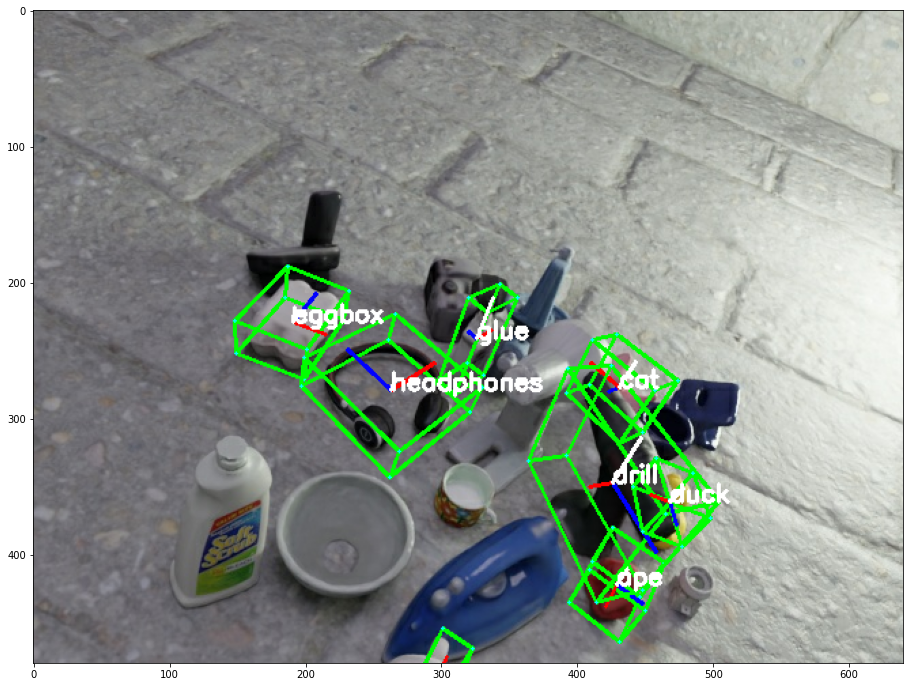

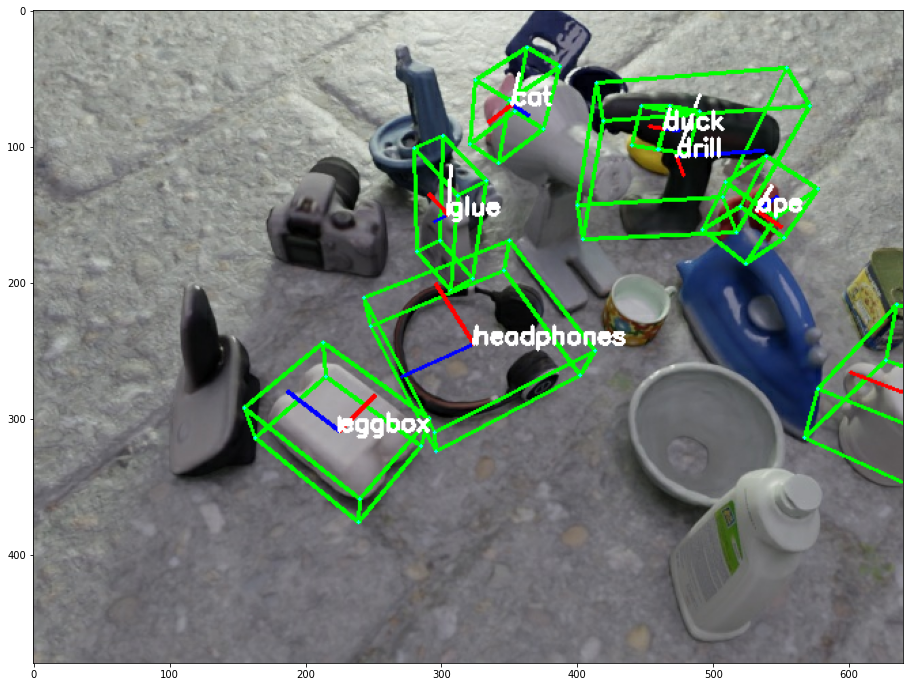

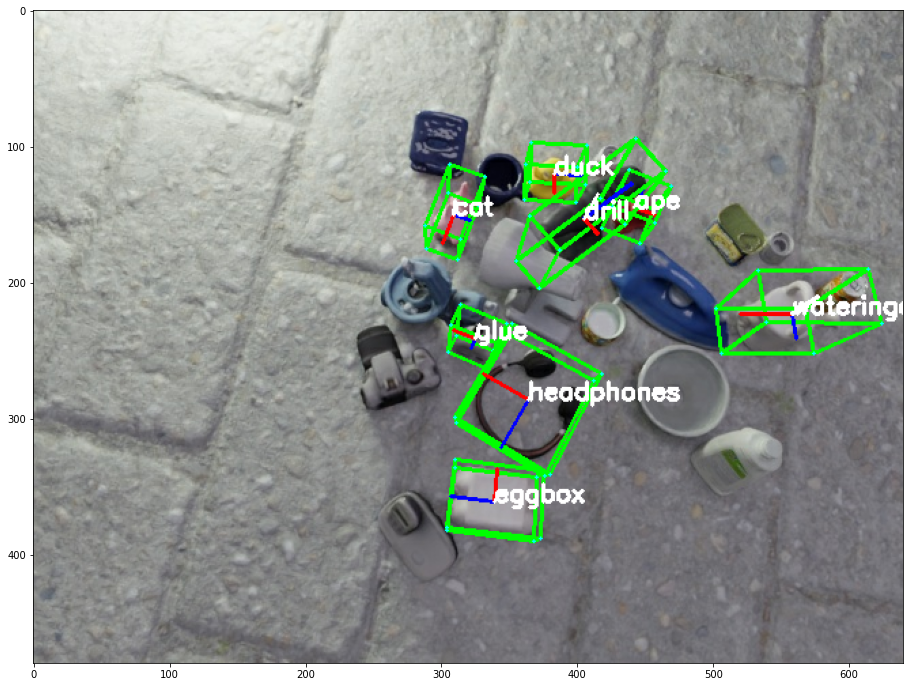

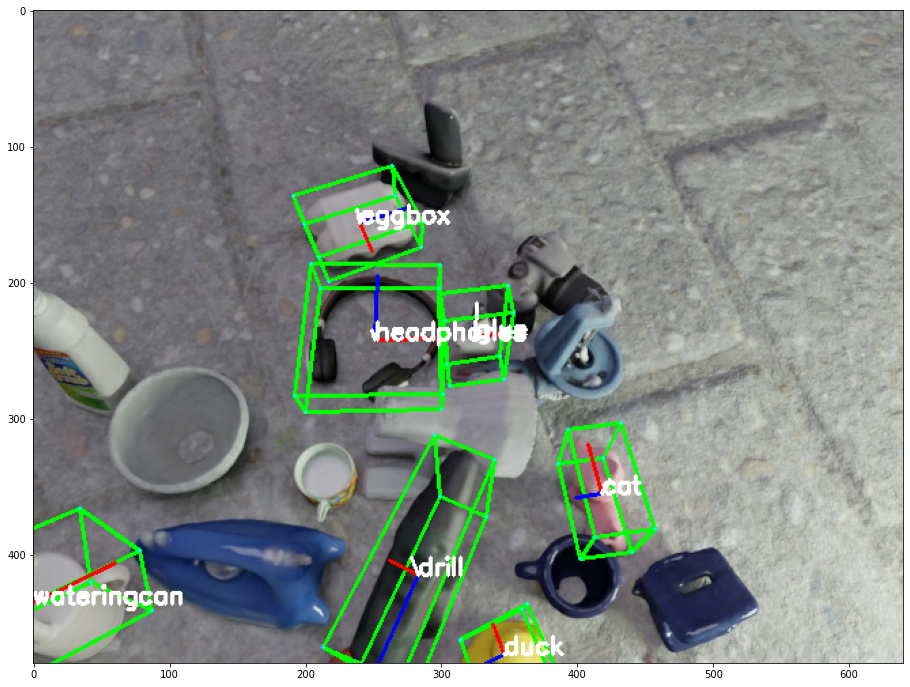

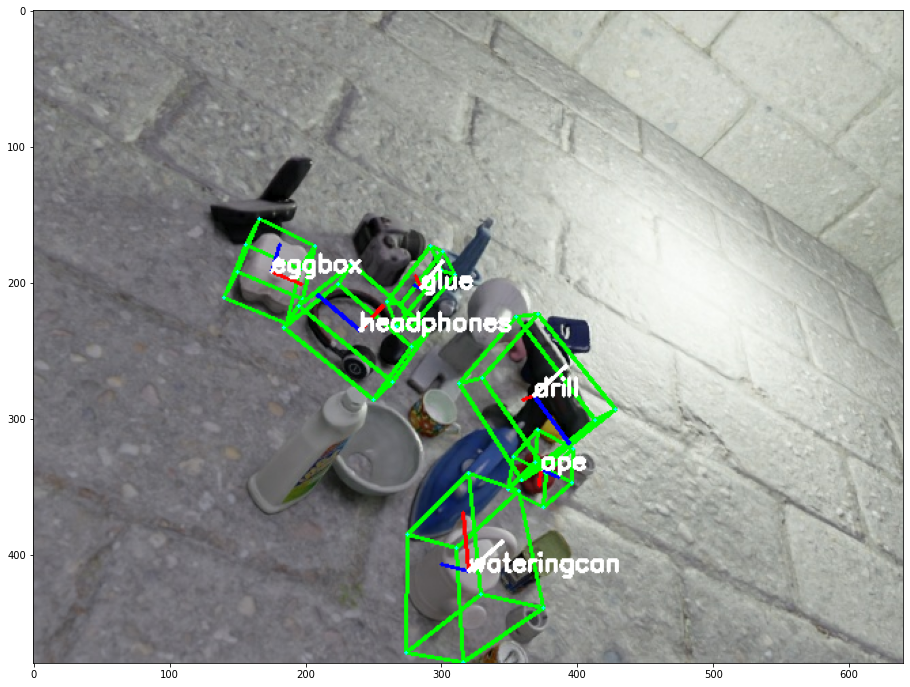

In [13]:
# CAMERA
cam_mat = camera_matrix[0]

# IMAGE
testingdata_iterator = iter(testingdata)

path_out = 'import_data/output'

for n, img_name in tqdm(enumerate(test_dataset.imgs), total=len(test_dataset.imgs)):
    img_batch = testingdata_iterator.get_next()
    ### IMAGEONLY
    img_batch = tf.expand_dims(img_batch, 0)
    img_batch = tuple(img_batch)

    img = img_batch[0][0]

    # EST POSE
    gt_poses = None
    poses_est = est_poses[n]
    poses_est = np.reshape(poses_est, (1, 8, 3, 4))
    estimated_poses=poses_est[0]

    file_prefix = img_name.split('/')[-1].split('.')[0]
    
    draw_bb_inference(
        img = img, 
        estimated_poses=estimated_poses,
        cuboids=cuboids,
        camera_matrix=cam_mat,
        path=path_out,
        file_prefix=file_prefix,
        gt_pose=gt_poses
    )